# ARXIV Scholar

In [32]:
import pandas as pd
import csv
import json
import ast
import requests
import matplotlib.pyplot as plt
from collections import OrderedDict
from operator import itemgetter
import graphics_parse as gp

In [33]:
# Clean dataset

def contains_number(string):
    return any(char.isdigit() for char in string)

with open('./data/arxivData.json', 'r') as dataset:
    papers = json.loads(dataset.read())

authors = set() # statistics purpose

for paper in papers:
    names = []

    # authors
    for author in ast.literal_eval(paper['author']):        
        names.append(author['name'])
        authors.add(author['name'])
    paper['authors'] = names

    # link
    for link in ast.literal_eval(paper['link']):
        if link['rel'] == 'alternate':
            paper['link'] = link['href']

    # date
    date = str(paper['year']) + '-' + str(paper['month']) + '-' +  str(paper['day']) 
    paper['date'] = date

    # tags
    tags = []
    for tag in ast.literal_eval(paper['tag']):
        if (contains_number(tag['term'])):
            continue
        tags.append(tag['term'])
    paper['tags'] = tags

    paper.pop('author')
    paper.pop('id')
    paper.pop('year')
    paper.pop('month')
    paper.pop('day')
    paper.pop('tag')

In [34]:
def getTitle(tag):
    URL = 'https://arxiv.org/list/'
    url = URL + tag + '/recent'

    response = requests.get(url)
    text = response.text

    dlPageIndex = text.find("dlpage")

    h1Index = text.find("<h1>", dlPageIndex+1)
    h1FinalIndex = text.find("</h1>", h1Index)

    result = text[h1Index+4:h1FinalIndex-1]
    return result

tagsDict = {}

nReqs = 0

for paper in papers:
    urlTags = paper['tags']
    newTags = []
    
    for tag in urlTags:
        if tag not in tagsDict.keys():
            tagsDict[tag] = getTitle(tag)
            nReqs+=1
        
        newTags.append(tagsDict[tag])
    paper['tags'] = newTags

print("Number of requests made: ", nReqs)

Number of requests made:  161


In [35]:
df = pd.DataFrame(papers)
df.to_csv('data/dateset.csv', index=False)  

In [36]:
df = pd.read_csv('data/dateset.csv')

In [44]:
# Some statistics about the dataset

print("Number of entries: ", len(papers))
    
print("Number of authors: ", len(authors))

print("Number of fields:", nReqs)

df.head()

Number of entries:  41000
Number of authors:  10
Number of fields: 161


,link,summary,title,authors,date,tags
0,http://arxiv.org/abs/1802.00209v1,We propose an architecture for VQA which utili...,Dual Recurrent Attention Units for Visual Ques...,"['Ahmed Osman', 'Wojciech Samek']",2018-2-1,"['Artificial Intelligence', 'Computation and L..."
1,http://arxiv.org/abs/1603.03827v1,Recent approaches based on artificial neural n...,Sequential Short-Text Classification with Recu...,"['Ji Young Lee', 'Franck Dernoncourt']",2016-3-12,"['Computation and Language', 'Artificial Intel..."
2,http://arxiv.org/abs/1606.00776v2,We introduce the multiresolution recurrent neu...,Multiresolution Recurrent Neural Networks: An ...,"['Iulian Vlad Serban', 'Tim Klinger', 'Gerald ...",2016-6-2,"['Computation and Language', 'Artificial Intel..."
3,http://arxiv.org/abs/1705.08142v2,Multi-task learning is motivated by the observ...,Learning what to share between loosely related...,"['Sebastian Ruder', 'Joachim Bingel', 'Isabell...",2017-5-23,"['Machine Learning', 'Artificial Intelligence'..."
4,http://arxiv.org/abs/1709.02349v2,We present MILABOT: a deep reinforcement learn...,A Deep Reinforcement Learning Chatbot,"['Iulian V. Serban', 'Chinnadhurai Sankar', 'M...",2017-9-7,"['Computation and Language', 'Artificial Intel..."


In [38]:
df.isnull().sum()

link       0
summary    0
title      0
authors    0
date       0
tags       0
dtype: int64

In [39]:
tags = {}
authors = {}
years = {}
for index, row in df.iterrows():

    # tags
    allTags = gp.splitString(row.tags)
    for tag in allTags:
        gp.checkExistance(tags, tag)

    # authors
    allAuthors = gp.splitString(row.authors)
    for author in allAuthors:
        gp.checkExistance(authors, author)

    # years
    gp.checkExistance(years, row.date[0:4])

In [40]:
# most relevant tags
tags['Others'] = 0
keys = []
for key in tags:
    if tags[key] < 3819:
        tags['Others'] += tags[key] 
    else:    
        keys.append(key)
tags = {key:tags[key] for key in tags if key in keys}

# top 10 authors
authors = dict(sorted(authors.items(), key= itemgetter(1), reverse=True)[:10])

# order years
years = OrderedDict(sorted(years.items()))

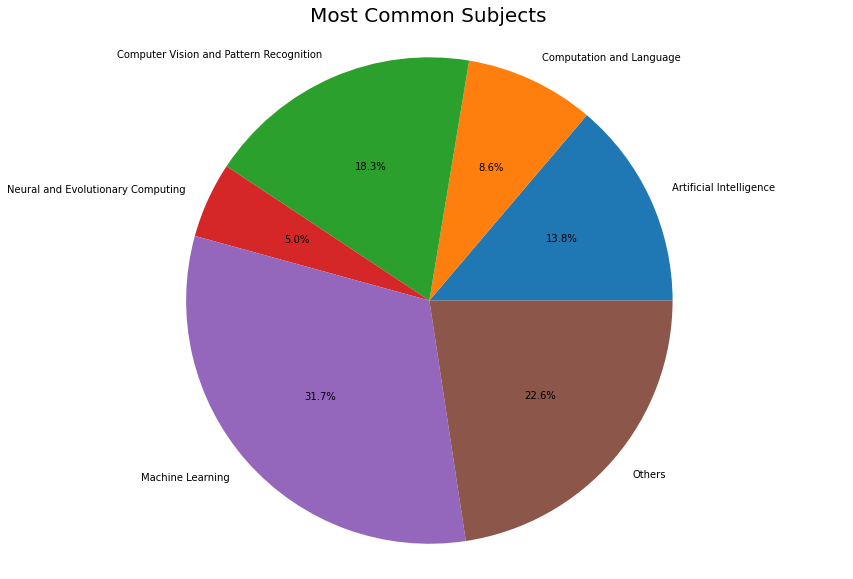

In [46]:
gp.piePlot(tags, 'Most Common Subjects', '../docs/res/tags.jpg')

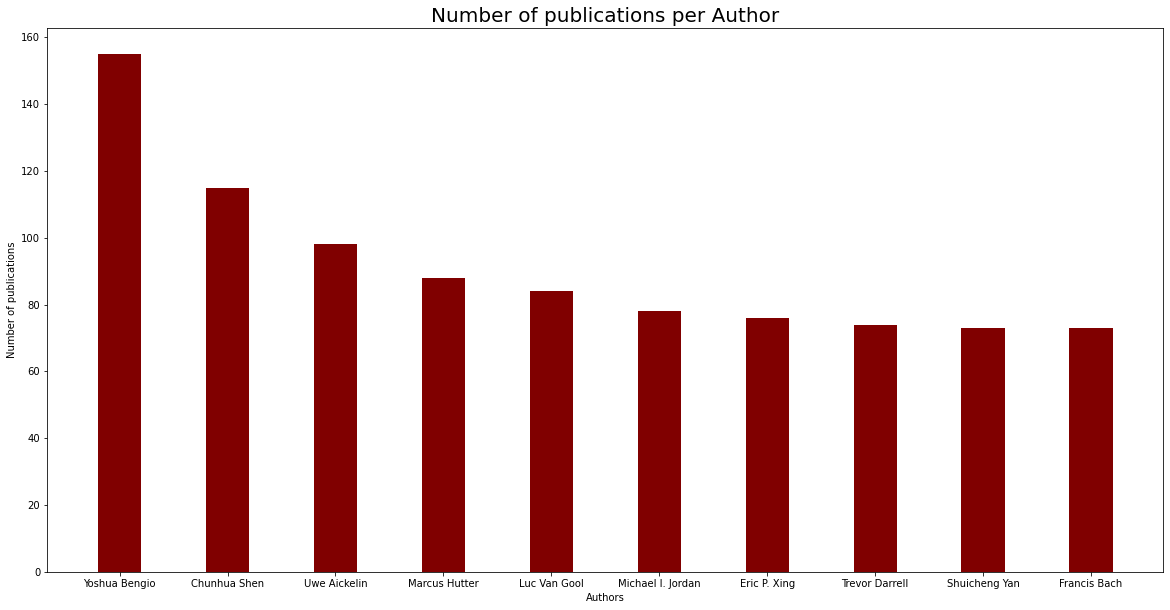

In [47]:
gp.barPlot(authors, 'Number of publications per Author', 'Authors', 'Number of publications', '../docs/res/pub_per_author.jpg')

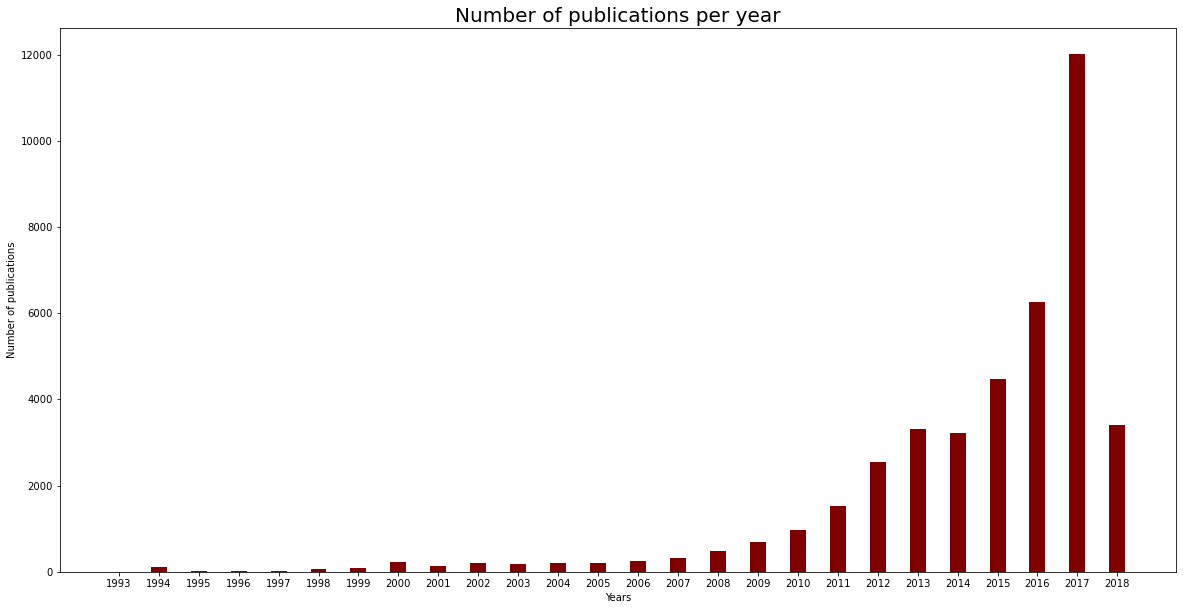

In [43]:
gp.barPlot(years, 'Number of publications per year', 'Years', 'Number of publications', '../docs/res/pub_per_year.jpg')